## MOCLIP Example Notebook

This notebook demonstrates how to download the MOCLIP model and test dataset, and evaluate its performance.

Let’s begin by setting up the model.

In [ ]:
# 1) Import necessary libraries
import torch
import yaml
import sys
from pathlib import Path
from types import SimpleNamespace

# 2) Add the parent directory to the system path to import custom modules
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# 3) Import the model's builder
from src.models.moclip import build_moclip

# 4) Load the configuration file
with open('../src/models/config.yaml', 'r') as file:
    cfg_dict = yaml.safe_load(file)

# Convert to SimpleNamespace for easy attribute access
cfg = SimpleNamespace(**cfg_dict)

# 5) Build the MoCLIP model using the configuration
moclip = build_moclip(cfg)

# 6) Choose the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 7) Move the model to the chosen device
moclip.to(device)

MOCLIPBasic(
  (geometry_encoder): ResNetCustom(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

The MOCLIP model consists of two main components: a geometry encoder and a spectra encoder. We explicitly extract these modules in order to proceed.

In [3]:
# Get Geometry and Spectra encoders
geometry_encoder = moclip.geometry_encoder
spectra_encoder = moclip.spectra_encoder

The MOCLIP model is now ready to process data. The next step is to prepare the dataset. In this example, we will use the test subset provided in `MOCLIP/data/MOCLIP_dataset_10k.npz`.

In [4]:
# 1) Import necessary libraries for data loading
import numpy as np

# 2) Load the dataset from the specified path
root = "../data/MOCLIP_dataset_10k.npz"
Dataset = np.load(root, allow_pickle=True)

# 3) Extract the relevant data from the loaded dataset
wvl = torch.from_numpy(Dataset['wvl']) # Shape (29,) wavelengths in nm 450-730

geom = torch.from_numpy(Dataset['geom']).float() # Shape (Batch, 128, 128)
params = torch.from_numpy(Dataset['params']).float() # Shape (Batch, 2) (period, thickness) in um
spectra = torch.from_numpy(np.concatenate([Dataset['spectra_x'], Dataset['spectra_y']], axis=1)).float() # Shape (Batch, 58)

With MOCLIP and the dataset prepared, we can now compute the R@K retrieval metrics to evaluate model performance.

In [5]:
# 1) Encode the geometry and spectra using the respective encoders
geom_emb = geometry_encoder(geom.unsqueeze(1).to(device), params.to(device)) # Shape (Batch, 64), Here we unsqueeze geom to add a channel dimension (Batch, 1, 128, 128)
spectra_emb = spectra_encoder(spectra.to(device)) # Shape (Batch, 64)

# 2) Normalize the embeddings to have unit length
import torch.nn.functional as F
geom_emb = F.normalize(geom_emb, p=2, dim=1)
spectra_emb = F.normalize(spectra_emb, p=2, dim=1)

# 3) Compute R@K for K=1, 5, 10 for both inverse design (geometry-to-spectra) and forward design (spectra-to-geometry)
from src.utils import recall_at_k

# Inverse design: Geometry-to-Spectra
r_at_1_geom_to_spectra = recall_at_k(geom_emb, spectra_emb, k=1)
r_at_5_geom_to_spectra = recall_at_k(geom_emb, spectra_emb, k=5)
r_at_10_geom_to_spectra = recall_at_k(geom_emb, spectra_emb, k=10)  

# Forward design: Spectra-to-Geometry
r_at_1_spectra_to_geom = recall_at_k(spectra_emb, geom_emb, k=1)
r_at_5_spectra_to_geom = recall_at_k(spectra_emb, geom_emb, k=5)
r_at_10_spectra_to_geom = recall_at_k(spectra_emb, geom_emb, k=10)  

# 4) Print the results
print("Recall@K for MOCLIP with 10k dataset:")
print(f"R@1 (Geometry-to-Spectra): {r_at_1_geom_to_spectra:.4f}")
print(f"R@5 (Geometry-to-Spectra): {r_at_5_geom_to_spectra:.4f}")
print(f"R@10 (Geometry-to-Spectra): {r_at_10_geom_to_spectra:.4f}")
print(f"R@1 (Spectra-to-Geometry): {r_at_1_spectra_to_geom:.4f}")
print(f"R@5 (Spectra-to-Geometry): {r_at_5_spectra_to_geom:.4f}")
print(f"R@10 (Spectra-to-Geometry): {r_at_10_spectra_to_geom:.4f}")

Recall@K for MOCLIP with 10k dataset:
R@1 (Geometry-to-Spectra): 0.8978
R@5 (Geometry-to-Spectra): 0.9905
R@10 (Geometry-to-Spectra): 0.9954
R@1 (Spectra-to-Geometry): 0.8982
R@5 (Spectra-to-Geometry): 0.9937
R@10 (Spectra-to-Geometry): 0.9973


It is often useful to visualize the similarity matrix for a selected subset of samples.

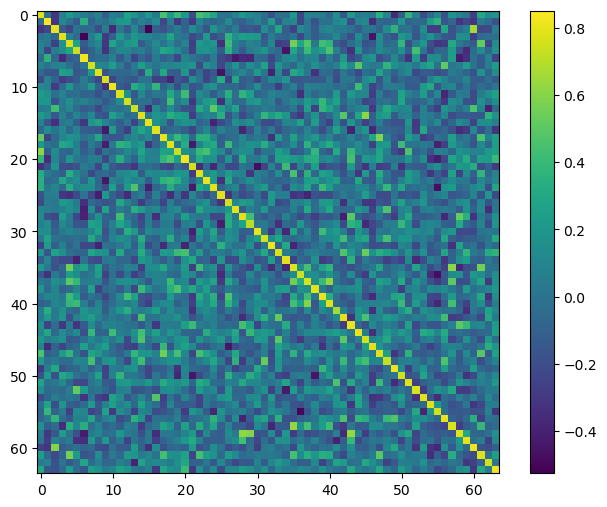

In [ ]:
# 1) Choose a random sample from the dataset
import random
sim_size = 64 # Choose any number of samples to visualize
random_indices = random.sample(range(geom.shape[0]), sim_size) # Randomly select sim_size indices
geom_emb_sample = geom_emb[random_indices] # Shape (sim_size, 64)
spectra_emb_sample = spectra_emb[random_indices] # Shape (sim_size, 64)

# 2) Compute the cosine similarity matrix between the geometry and spectra embeddings
similarity_matrix = geom_emb_sample @ spectra_emb_sample.T # Shape (sim_size, sim_size)

# 3) Plot the similarity matrix 
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix.cpu().numpy())
plt.colorbar()